In [ ]:
# HMDB51 Action Recognition with R(2+1)D + Enhanced MoE (Dynamic Routing) on Kaggle

"""
This notebook trains or loads a pre-trained action recognition model
on the HMDB51 dataset using an enhanced Mixture of Experts (MoE) layer
with dynamic routing features on top of an R(2+1)D backbone, incorporating
a module to learn motion dynamics from features.

**Functionality:**
1. Installs necessary libraries (`rarfile`, `unrar`).
2. Downloads HMDB51 videos and split files (if not already present).
3. Extracts the RAR files, handling nested structures (if not already extracted).
4. Checks if a model checkpoint exists for the `CURRENT_SPLIT`.
5. **Loads** the checkpoint if found.
6. **Trains** a new model if the checkpoint is not found (saving the best version).
7. Evaluates the final model (loaded or trained) on the test set.
8. Provides an example of single video inference and user upload.

**Improvements over base:**
- Motion Dynamics Module capturing feature-level motion.
- MLP-based MoE gating network (more "dynamic" routing).
- Noisy Top-K gating during training for robustness.
- Residual MLP Experts for increased capacity.
"""

'\nThis notebook trains or loads a pre-trained action recognition model\non the HMDB51 dataset using an enhanced Mixture of Experts (MoE) layer\nwith dynamic routing features on top of an R(2+1)D backbone, incorporating\na module to learn motion dynamics from features.\n\n**Functionality:**\n1. Installs necessary libraries (`rarfile`, `unrar`).\n2. Downloads HMDB51 videos and split files (if not already present).\n3. Extracts the RAR files, handling nested structures (if not already extracted).\n4. Checks if a model checkpoint exists for the `CURRENT_SPLIT`.\n5. **Loads** the checkpoint if found.\n6. **Trains** a new model if the checkpoint is not found (saving the best version).\n7. Evaluates the final model (loaded or trained) on the test set.\n8. Provides an example of single video inference and user upload.\n\n**Improvements over base:**\n- Motion Dynamics Module capturing feature-level motion.\n- MLP-based MoE gating network (more "dynamic" routing).\n- Noisy Top-K gating during t

In [ ]:
# --- Installations ---
print("Installing required packages...")
# Install Python library for RAR files
!pip install rarfile -q

# Install the 'unrar' system utility (needed by rarfile)
print("Installing 'unrar' system utility...")
!apt-get update && apt-get install -y -qq unrar

print("Installations complete.")

Installing required packages...
Installing 'unrar' system utility...
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]                
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]                           
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]                                
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]                             
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,824 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]    
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]           
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubu

In [ ]:
# --- Imports ---
import os
import rarfile
import shutil
import random
import numpy as np
import cv2
import time
import requests
from tqdm.notebook import tqdm
from collections import defaultdict
import gc # Garbage collector
import math
import warnings
import traceback
import base64

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, Image, HTML


# Ignore specific warnings if they become noisy
# warnings.filterwarnings("ignore", category=UserWarning, module='torchvision')

print("Imports complete.")

Imports complete.


In [ ]:
# --- Configuration ---

print("--- Setting Configuration ---")
# --- Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if not torch.cuda.is_available():
    print("WARNING: CUDA (GPU) not available. Training/Inference will be very slow.")

# --- Paths (Kaggle specific) ---
BASE_OUTPUT_PATH = '/kaggle/working/'
BASE_DATA_PATH = os.path.join(BASE_OUTPUT_PATH, 'data')
MODEL_SAVE_PATH = os.path.join(BASE_OUTPUT_PATH, 'models')
USER_UPLOAD_PATH = os.path.join(BASE_OUTPUT_PATH, 'user_uploads')

DATASET_PATH = os.path.join(BASE_DATA_PATH, 'hmdb51_extracted')
SPLIT_PATH = os.path.join(BASE_DATA_PATH, 'splits_extracted')
HMDB51_RAR_PATH = os.path.join(BASE_DATA_PATH, 'hmdb51_org.rar')
SPLITS_RAR_PATH = os.path.join(BASE_DATA_PATH, 'test_train_splits.rar')

# Create directories
os.makedirs(BASE_DATA_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(USER_UPLOAD_PATH, exist_ok=True)

# --- Dataset & Model Hyperparameters ---
NUM_CLASSES = 51       # Expected number of classes in HMDB51
NUM_FRAMES = 16        # Number of frames to sample from each video
IMG_SIZE = 112         # Spatial size for frames

# --- MoE Hyperparameters ---
NUM_EXPERTS = 8        # Number of expert networks
TOP_K = 2            # Number of experts to route to
GATE_HIDDEN_DIM = 256 # Hidden dimension for the MLP gate
EXPERT_HIDDEN_DIM = 512 # Hidden dimension for MLP experts
NOISY_GATING_STD = 0.1 # Std dev for noise added to gate logits during training (set to 0 to disable)

# --- Motion Dynamics Module ---
MOTION_FEATURE_DIM = 128 # Intermediate dim for motion module

# --- Training Hyperparameters ---
CURRENT_SPLIT = 1      # Which HMDB51 split to use (1, 2, or 3)
BATCH_SIZE = 20         # Reduced slightly due to potentially larger model
LEARNING_RATE = 1e-4
NUM_EPOCHS = 40        # Only runs if model not found
LOAD_BALANCE_ALPHA = 0.01 # Coefficient for load balancing loss
WEIGHT_DECAY = 1e-5     # Added weight decay

# --- URLs ---
HMDB51_URL = "http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar"
SPLITS_URL = "http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar"

# --- Model Checkpoint Filename ---
MODEL_FILENAME = f"hmdb51_dynamic_moe_split{CURRENT_SPLIT}_best.pth" # Updated name
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_PATH, MODEL_FILENAME)

print("\nConfiguration Parameters:")
print(f"  Target Split: {CURRENT_SPLIT}")
print(f"  Device: {DEVICE}")
print(f"  Num Epochs (if training): {NUM_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Num Frames: {NUM_FRAMES}")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Num Experts: {NUM_EXPERTS}")
print(f"  Top-K Routing: {TOP_K}")
print(f"  Gate Hidden Dim: {GATE_HIDDEN_DIM}")
print(f"  Expert Hidden Dim: {EXPERT_HIDDEN_DIM}")
print(f"  Noisy Gating Std (Train): {NOISY_GATING_STD}")
print(f"  Motion Feature Dim: {MOTION_FEATURE_DIM}")
print(f"  Dataset Path: {DATASET_PATH}")
print(f"  Split Path: {SPLIT_PATH}")
print(f"  Model Save Path: {MODEL_SAVE_PATH}")
print(f"  Best Model File: {BEST_MODEL_PATH}")
print("\nReminder: Ensure Internet is ON in Kaggle settings for downloads.")
print("Configuration Set.")

--- Setting Configuration ---
Using device: cuda

Configuration Parameters:
  Target Split: 1
  Device: cuda
  Num Epochs (if training): 40
  Batch Size: 20
  Learning Rate: 0.0001
  Weight Decay: 1e-05
  Num Frames: 16
  Image Size: 112
  Num Experts: 8
  Top-K Routing: 2
  Gate Hidden Dim: 256
  Expert Hidden Dim: 512
  Noisy Gating Std (Train): 0.1
  Motion Feature Dim: 128
  Dataset Path: /kaggle/working/data/hmdb51_extracted
  Split Path: /kaggle/working/data/splits_extracted
  Model Save Path: /kaggle/working/models
  Best Model File: /kaggle/working/models/hmdb51_dynamic_moe_split1_best.pth

Reminder: Ensure Internet is ON in Kaggle settings for downloads.
Configuration Set.


In [ ]:
# --- Download Function ---
def download_file(url, save_path):
    """Downloads a file with progress bar, skips if exists."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)} from {url}...")
        try:
            response = requests.get(url, stream=True, timeout=600) # Increased timeout
            response.raise_for_status()
            total_size = int(response.headers.get('content-length', 0))
            block_size = 16384 # Larger block size

            with open(save_path, 'wb') as f, tqdm(
                desc=os.path.basename(save_path), total=total_size, unit='iB',
                unit_scale=True, unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(block_size):
                    size = f.write(data)
                    bar.update(size)

            dl_size = os.path.getsize(save_path)
            min_expected_size_mb = 10 # Check against a minimum size if total_size is 0
            if total_size == 0 and dl_size < min_expected_size_mb * 1024 * 1024:
                 print(f"\nWARNING: Downloaded {save_path} size ({dl_size/1024/1024:.2f} MB) is small and content-length was 0. May be incomplete.")
                 # Allow proceeding but warn user
            elif total_size != 0 and dl_size < total_size:
                 print(f"\nERROR: Download incomplete for {save_path}. Expected {total_size}, got {dl_size}.")
                 os.remove(save_path); return False
            elif dl_size == 0 and total_size != 0:
                 print(f"\nERROR: Downloaded file {save_path} is zero size.")
                 os.remove(save_path); return False

            print(f"Download complete: {save_path} ({dl_size/1024/1024:.2f} MB)")
            return True
        except requests.exceptions.RequestException as e:
            print(f"\nERROR downloading {url}: {e}")
            if os.path.exists(save_path): os.remove(save_path)
            return False
        except Exception as e:
             print(f"\nERROR during download: {e}")
             if os.path.exists(save_path): os.remove(save_path)
             return False
    else:
        print(f"File already exists: {save_path}. Skipping download.")
        return True

In [ ]:
# --- Execute Downloads ---
print("\n--- Checking/Downloading Dataset Files ---")
hmdb_downloaded = download_file(HMDB51_URL, HMDB51_RAR_PATH)
splits_downloaded = download_file(SPLITS_URL, SPLITS_RAR_PATH)

if not hmdb_downloaded or not splits_downloaded:
    print("\nERROR: Failed to download required dataset files. Cannot proceed.")
    # raise Exception("Required file download failed.") # Optional: stop execution
else:
    print("\nDownload check complete.")


--- Checking/Downloading Dataset Files ---
File already exists: /kaggle/working/data/hmdb51_org.rar. Skipping download.
File already exists: /kaggle/working/data/test_train_splits.rar. Skipping download.

Download check complete.


In [ ]:
# --- Extract Function (Handles Nested RARs) ---
def extract_rar(rar_path, extract_path):
    """Extracts RAR files, handling potential nested structures in HMDB51."""
    # --- Determine if extraction is needed ---
    is_fully_extracted = False
    if rar_path == SPLITS_RAR_PATH:
        expected_file = os.path.join(extract_path, 'brush_hair_test_split1.txt')
        if os.path.exists(expected_file): is_fully_extracted = True
    elif rar_path == HMDB51_RAR_PATH:
        expected_folder = os.path.join(extract_path, 'brush_hair')
        if os.path.isdir(expected_folder):
            try:
                if any(f.endswith('.avi') for f in os.listdir(expected_folder) if os.path.isfile(os.path.join(expected_folder, f))):
                    is_fully_extracted = True
            except Exception: pass

    if is_fully_extracted:
        print(f"Target {extract_path} seems fully extracted for {os.path.basename(rar_path)}. Skipping.")
        return True

    print(f"Extraction needed for {os.path.basename(rar_path)} into {extract_path}")
    if os.path.exists(extract_path):
        print(f"Removing existing potentially incomplete directory: {extract_path}")
        try: shutil.rmtree(extract_path)
        except Exception as e: print(f"Warning: Could not remove {extract_path}: {e}")
    try:
        os.makedirs(extract_path, exist_ok=True)
    except Exception as e: print(f"ERROR: Could not create dir {extract_path}: {e}"); return False

    if not os.path.exists(rar_path):
         print(f"ERROR: RAR file not found: {rar_path}. Cannot extract."); return False

    print(f"Extracting {rar_path} to {extract_path}...")
    if rar_path == HMDB51_RAR_PATH: print("This might take 15-30+ minutes...")
    start_time = time.time()
    extraction_successful = False
    try:
        with rarfile.RarFile(rar_path, 'r') as rf:
            rf.extractall(path=extract_path)
        print(f"Initial extraction complete.")

        # Handle HMDB51 nested RARs
        if rar_path == HMDB51_RAR_PATH:
            print("Scanning for and extracting nested action RARs...")
            action_rars = [f for f in os.listdir(extract_path) if f.endswith('.rar') and os.path.isfile(os.path.join(extract_path, f))]
            errors_extracting = 0
            for action_rar_filename in tqdm(action_rars, desc="Extracting action RARs"):
                action_rar_path = os.path.join(extract_path, action_rar_filename)
                action_name = os.path.splitext(action_rar_filename)[0]
                action_class_folder = os.path.join(extract_path, action_name)
                try:
                    os.makedirs(action_class_folder, exist_ok=True)
                    with rarfile.RarFile(action_rar_path, 'r') as vf:
                        vf.extractall(path=action_class_folder)
                    # Handle potential extra nesting (e.g., brush_hair/brush_hair/)
                    nested_action_folder = os.path.join(action_class_folder, action_name)
                    if os.path.isdir(nested_action_folder):
                        dir_items_parent = os.listdir(action_class_folder)
                        if len(dir_items_parent) == 1 and dir_items_parent[0] == action_name:
                            for item in os.listdir(nested_action_folder):
                                shutil.move(os.path.join(nested_action_folder, item), os.path.join(action_class_folder, item))
                            try: os.rmdir(nested_action_folder)
                            except OSError: print(f"Warning: Could not remove empty nested dir: {nested_action_folder}")
                    os.remove(action_rar_path)
                except Exception as e: print(f"\nERROR processing {action_rar_path}: {e}"); errors_extracting += 1
            print(f"Action RAR extraction finished. Encountered {errors_extracting} errors.")
            if errors_extracting == 0: extraction_successful = True

        # Handle Splits potential subfolder
        elif rar_path == SPLITS_RAR_PATH:
             potential_subfolder = os.path.join(extract_path, 'testTrainMulti_7030_splits')
             if os.path.isdir(potential_subfolder):
                 dir_items_extract = os.listdir(extract_path)
                 if len(dir_items_extract) == 1 and dir_items_extract[0] == 'testTrainMulti_7030_splits':
                    print(f"Moving split files up from {potential_subfolder}.")
                    for item in os.listdir(potential_subfolder):
                        shutil.move(os.path.join(potential_subfolder, item), os.path.join(extract_path, item))
                    try: os.rmdir(potential_subfolder); print("Split files moved.")
                    except OSError: print(f"Warning: Could not remove empty splits subfolder: {potential_subfolder}")
             extraction_successful = True # Assume success unless verified otherwise

        # Final verification
        if extraction_successful: # Only verify if previous steps seemed ok
            if rar_path == SPLITS_RAR_PATH:
                expected_file = os.path.join(extract_path, 'brush_hair_test_split1.txt')
                if not os.path.exists(expected_file): extraction_successful = False; print("ERROR: Split file verification failed.")
            elif rar_path == HMDB51_RAR_PATH:
                expected_folder = os.path.join(extract_path, 'brush_hair')
                if not os.path.isdir(expected_folder): extraction_successful = False; print("ERROR: Action folder verification failed.")

    except Exception as e:
        print(f"\nERROR during extraction: {e}"); extraction_successful = False

    duration = time.time() - start_time
    print(f"Extraction process for {os.path.basename(rar_path)} took {duration:.2f} seconds. Success: {extraction_successful}")
    return extraction_successful

print("\nExtract function defined.")


Extract function defined.


In [ ]:
# --- Execute Extractions ---
hmdb_extracted = False
splits_extracted = False

if hmdb_downloaded and splits_downloaded:
    print("\n--- Checking/Extracting Dataset Files ---")
    hmdb_extracted = extract_rar(HMDB51_RAR_PATH, DATASET_PATH)
    gc.collect()
    splits_extracted = extract_rar(SPLITS_RAR_PATH, SPLIT_PATH)
    gc.collect()

    if not hmdb_extracted or not splits_extracted:
        print("\nERROR: Failed to extract required dataset files correctly. Cannot proceed.")
    else:
        print("\nExtraction check complete.")
        print("\n--- Sample Extracted Dataset Content ---")
        # Check if path exists using Python's os.path.exists
        if os.path.exists(DATASET_PATH):
            # If it exists, execute the shell command on a new line (indented)
            !ls -d "{DATASET_PATH}"/*/ | head -n 5
        else:
            # If it doesn't exist, print a message
            print(f"Dataset path {DATASET_PATH} not found.")

        print("\n--- Sample Extracted Split Content ---")
        # Check if path exists using Python's os.path.exists
        if os.path.exists(SPLIT_PATH):
            # If it exists, execute the shell command on a new line (indented)
            !ls "{SPLIT_PATH}" | head -n 5
        else:
             # If it doesn't exist, print a message
             print(f"Split path {SPLIT_PATH} not found.")
else:
    print("\nSkipping extraction because download failed.")

# Set flag indicating whether data is ready for subsequent steps
data_ready_for_loading = hmdb_extracted and splits_extracted
if not data_ready_for_loading:
     print("\n##############################################################")
     print("WARNING: Data extraction failed or was skipped. Downstream steps might fail.")
     print("##############################################################")


--- Checking/Extracting Dataset Files ---
Target /kaggle/working/data/hmdb51_extracted seems fully extracted for hmdb51_org.rar. Skipping.
Target /kaggle/working/data/splits_extracted seems fully extracted for test_train_splits.rar. Skipping.

Extraction check complete.

--- Sample Extracted Dataset Content ---
/kaggle/working/data/hmdb51_extracted/brush_hair/
/kaggle/working/data/hmdb51_extracted/cartwheel/
/kaggle/working/data/hmdb51_extracted/catch/
/kaggle/working/data/hmdb51_extracted/chew/
/kaggle/working/data/hmdb51_extracted/clap/

--- Sample Extracted Split Content ---
brush_hair_test_split1.txt
brush_hair_test_split2.txt
brush_hair_test_split3.txt
cartwheel_test_split1.txt
cartwheel_test_split2.txt


In [ ]:
# --- Dataset Definitions (Load Split, Sample Frames, Dataset Class, Collate Fn) ---

# --- Helper Functions ---
def load_split(split_path, split_index, num_classes_expected):
    """Loads train/test file lists and labels for a given split index (1, 2, or 3)."""
    train_videos = defaultdict(list)
    test_videos = defaultdict(list)
    action_map = {}
    class_id_counter = 0

    if not os.path.isdir(split_path):
        print(f"Error: Split path does not exist: {split_path}"); return None, None, None
    split_files = sorted([f for f in os.listdir(split_path) if f.endswith(f'_test_split{split_index}.txt')])
    if not split_files:
        print(f"Error: No split files found for index {split_index} in {split_path}"); return None, None, None

    print(f"Loading split {split_index} using {len(split_files)} action files...")
    actions_found = set()
    for filename in split_files:
        action_name = "_".join(filename.split('_')[:-2])
        actions_found.add(action_name)
        if action_name not in action_map:
            action_map[action_name] = class_id_counter; class_id_counter += 1
        label_id = action_map[action_name]
        filepath = os.path.join(split_path, filename)
        try:
            with open(filepath) as f:
                for line in f:
                    parts = line.strip().split();
                    if len(parts) >= 2: # Ensure at least 2 parts
                        video_name, split_label_str = parts[:2]
                        try: split_label = int(split_label_str)
                        except ValueError: continue
                        if split_label == 1: train_videos[action_name].append(video_name)
                        elif split_label == 2: test_videos[action_name].append(video_name)
        except Exception as e: print(f"Error reading {filepath}: {e}")

    num_classes_found = len(action_map)
    print(f"Split {split_index}: Found {num_classes_found} classes.")
    total_train = sum(len(v) for v in train_videos.values()); total_test = sum(len(v) for v in test_videos.values())
    print(f"Total train/test videos parsed: {total_train}/{total_test}")

    if num_classes_found != num_classes_expected and total_train > 0 :
        print(f"Warning: Expected {num_classes_expected} classes, but found {num_classes_found}.")
    if total_train == 0 or total_test == 0:
        print("Error: Failed to load sufficient train/test videos."); return None, None, None
    return train_videos, test_videos, action_map


def sample_frames(video_path, num_frames, img_size):
    """Samples frames uniformly from a video."""
    frames = []
    cap = None
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened(): return None
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames < 1: return None

        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        if total_frames < num_frames: # Handle short videos
             # Repeat frames from the beginning if video is too short
            indices = np.tile(np.arange(total_frames), (num_frames + total_frames - 1) // total_frames)[:num_frames]
            indices = np.sort(indices) # Ensure temporal order if padded

        processed_frames = 0
        for i in indices:
            # Ensure index is within valid range, even after padding/tiling logic
            current_frame_index = min(i, total_frames - 1)
            cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_index)
            ret, frame = cap.read()
            if ret:
                try:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
                    frames.append(frame)
                    processed_frames += 1
                except Exception: continue # Skip frame processing error

        if processed_frames == 0: return None

        # Pad if needed after processing (e.g., if reading frames failed mid-way)
        while len(frames) < num_frames and frames:
              frames.append(frames[-1].copy()) # Pad with last valid frame
        if not frames: return None # Failed if still no frames

        return np.stack(frames) # Shape: (num_frames, img_size, img_size, 3)
    except Exception as e:
        # print(f"Error sampling {video_path}: {e}") # Reduce noise
        return None
    finally:
        if cap is not None: cap.release()


# --- Dataset Class (with Manual Normalization) ---
class HMDB51Dataset(Dataset):
    def __init__(self, dataset_path, split_videos, action_map, num_frames, img_size, is_train=True):
        self.dataset_path = dataset_path
        self.split_videos = split_videos
        self.action_map = action_map
        self.num_frames = num_frames
        self.img_size = img_size
        self.is_train = is_train
        self.video_list = self._create_video_list()

        # R(2+1)D normalization constants (from torchvision weights)
        # Define them on CPU initially, move to device in __getitem__ if needed
        self.mean_cpu = torch.tensor([0.43216, 0.394666, 0.37645]).view(3, 1, 1, 1)
        self.std_cpu = torch.tensor([0.22803, 0.22145, 0.216989]).view(3, 1, 1, 1)

        if not self.video_list:
            if self.split_videos is not None: print("Error: Video list empty. Check path/extraction/split files.")
            raise ValueError("Failed to create video list.")
        print(f"Dataset ({'Train' if is_train else 'Test'}) created. Found {len(self.video_list)} valid videos.")

    def _create_video_list(self):
        video_list = []
        print("Creating video list...")
        if not self.split_videos: return []
        missing_files, skipped_empty, action_folders_missing = 0, 0, set()

        for action_name, video_names in tqdm(self.split_videos.items(), desc="Mapping videos", leave=False):
            if action_name not in self.action_map: continue
            label_id = self.action_map[action_name]
            action_folder = os.path.join(self.dataset_path, action_name)
            if not os.path.isdir(action_folder):
                 if action_name not in action_folders_missing: action_folders_missing.add(action_name)
                 missing_files += len(video_names); continue

            for video_name in video_names:
                 clean_video_name = video_name.strip();
                 if not clean_video_name: continue
                 video_path = os.path.join(action_folder, clean_video_name)
                 if os.path.exists(video_path):
                      try:
                          # Check size > 1KB as a basic validity check
                          if os.path.getsize(video_path) > 1024: video_list.append((video_path, label_id))
                          else: skipped_empty += 1
                      except OSError: missing_files += 1 # File exists but cannot access size
                 else: missing_files += 1

        if missing_files > 0: print(f"Warning: {missing_files} video files from split not found/accessible.")
        if skipped_empty > 0: print(f"Warning: Skipped {skipped_empty} potentially empty videos (<=1KB).")
        if action_folders_missing: print(f"Warning: Action folders missing for: {', '.join(sorted(list(action_folders_missing)))}")
        if not video_list: print("Error: No video files successfully mapped.")
        return video_list

    def __len__(self): return len(self.video_list)

    def __getitem__(self, idx):
        max_retries = 2
        original_idx = idx # Keep track of the initially requested index for logging

        for attempt in range(max_retries):
            current_idx = idx
            # If retrying on training set, pick a random different index
            if attempt > 0 and self.is_train:
                while True:
                    current_idx = random.randint(0, len(self) - 1)
                    if current_idx != original_idx: break # Ensure it's not the original failed one
            # If retrying on test set, stop after first attempt
            elif attempt > 0 and not self.is_train: break

            if current_idx >= len(self.video_list): continue # Should not happen with randint logic
            video_path, label = self.video_list[current_idx]

            frames = sample_frames(video_path, self.num_frames, self.img_size)
            if frames is not None:
                try:
                    # Convert numpy array (T, H, W, C) to PyTorch tensor (C, T, H, W)
                    frames_tensor = torch.from_numpy(frames).float().permute(3, 0, 1, 2)

                    # Normalize: Convert to [0, 1] then apply mean/std
                    frames_tensor /= 255.0
                    # Move normalization tensors to the same device as the data potentially will be
                    mean = self.mean_cpu.to(frames_tensor.device)
                    std = self.std_cpu.to(frames_tensor.device)
                    frames_tensor = (frames_tensor - mean) / std # Normalize

                    return frames_tensor, label # Success
                except Exception as e:
                    # Log error only on the first attempt for the original index to reduce noise
                    if attempt == 0 and current_idx == original_idx:
                        # print(f"Error processing tensor {video_path} (idx {original_idx}): {e}") # Reduce noise
                        pass
            # --- Retry Logic ---
            # If frames is None or an exception occurred, the loop continues to the next attempt/index.
            if attempt < max_retries - 1:
                 if attempt == 0 and current_idx == original_idx and self.is_train:
                      # print(f"Retrying for failed training item {original_idx}...") # Reduce noise
                      pass
            # No need for explicit 'continue', loop naturally proceeds

        # --- Fallback ---
        # Only print warning for the originally requested item if all attempts fail
        # if idx == original_idx:
             # print(f"Warning: Failed to load video idx {original_idx} after {attempt+1} attempts. Returning None.") # Reduce noise
        return None, None # Signal failure


# --- Collate Function ---
def collate_fn(batch):
    """Filters out None values from a batch and collates valid items."""
    # Filter out items where either the frame tensor or the label is None
    batch = [item for item in batch if item is not None and item[0] is not None and item[1] is not None]

    if not batch:
        # Return empty tensors with correct dimensions if possible
        # Shape: (B, C, T, H, W)
        return torch.empty((0, 3, NUM_FRAMES, IMG_SIZE, IMG_SIZE), dtype=torch.float), \
               torch.empty((0,), dtype=torch.long) # Shape: (B,)
    try:
        # Use default collate to stack tensors along a new batch dimension
        return torch.utils.data.dataloader.default_collate(batch)
    except Exception as e:
        print(f"Error in collate_fn: {e}. Returning empty batch.")
        # Return empty tensors if default collate fails
        return torch.empty((0, 3, NUM_FRAMES, IMG_SIZE, IMG_SIZE), dtype=torch.float), \
               torch.empty((0,), dtype=torch.long)

print("\nDataset and Dataloader definitions complete.")


Dataset and Dataloader definitions complete.


In [ ]:
# --- Model Architecture Definitions ---

# --- Motion Dynamics Module ---
class MotionDynamicsModule(nn.Module):
    """
    Learns motion dynamics from adjacent feature maps.
    Input: (B, C, T, H, W) feature tensor
    Output: (B, C, T-1, H, W) motion-enhanced features (if output_same_dim=True)
            or (B, hidden_dim, T-1, H, W) otherwise.
    """
    def __init__(self, input_dim, hidden_dim=MOTION_FEATURE_DIM, output_same_dim=True):
        super().__init__()
        self.output_same_dim = output_same_dim
        # Conv to process differences: captures motion patterns
        # Kernel size 1 in time ensures we only look at adjacent frame differences
        self.motion_conv = nn.Conv3d(input_dim, hidden_dim, kernel_size=(1, 3, 3), padding=(0, 1, 1), bias=False)
        self.norm = nn.BatchNorm3d(hidden_dim)
        self.relu = nn.ReLU(inplace=True)

        # Conv to restore original dimension if output_same_dim is True and hidden_dim != input_dim
        if output_same_dim and hidden_dim != input_dim:
            self.out_conv = nn.Conv3d(hidden_dim, input_dim, kernel_size=1)
        elif not output_same_dim:
            # If output_same_dim is False, we don't need out_conv unless specifically requested elsewhere
             pass


    def forward(self, x):
        # x shape: (B, C, T, H, W)
        if x.size(2) < 2: # Need at least 2 time steps to compute difference
             # If T=1, cannot compute diff. Return 0s of expected output shape.
            target_t = max(0, x.size(2) - 1) # Target time dimension T-1
            # Determine output channel count
            out_c = x.size(1) if self.output_same_dim else self.motion_conv.out_channels
            return torch.zeros(x.size(0), out_c, target_t, x.size(3), x.size(4), device=x.device, dtype=x.dtype)

        # Calculate frame differences along time dimension T
        diff = x[:, :, 1:, :, :] - x[:, :, :-1, :, :] # (B, C, T-1, H, W)

        # Learn motion patterns from differences
        motion_features = self.motion_conv(diff) # (B, hidden_dim, T-1, H, W)
        motion_features = self.relu(self.norm(motion_features))

        # Project back to input dimension if needed
        if self.output_same_dim and hasattr(self, 'out_conv'):
             motion_features = self.out_conv(motion_features) # (B, C, T-1, H, W)

        # Return features derived from the *difference*, representing dynamics.
        return motion_features # (B, output_C, T-1, H, W)


# --- Enhanced Expert MLP ---
class ResidualExpertMLP(nn.Module):
    """MLP expert with a residual connection."""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Dropout after first activation
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) # Added layer
        self.relu2 = nn.ReLU()
        # No dropout after second activation/residual, before final FC

        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Projection for residual connection if input_dim != hidden_dim
        self.proj = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()


    def forward(self, x):
        identity = self.proj(x) # Project input for residual path

        # Main path
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout(out) # Apply dropout here
        out = self.fc2(out)
        # Add residual *before* the second ReLU? Or after? Let's try before.
        out = out + identity # Add residual to the output of fc2
        out = self.relu2(out) # Apply final activation for this block

        # Final output layer
        out = self.fc3(out)
        return out


# --- Enhanced MoE Layer ---
class DynamicTopKMoE(nn.Module):
    """MoE layer with MLP gate and optional noisy top-k during training."""
    def __init__(self, input_dim, num_experts, top_k, expert_hidden_dim, output_dim,
                 gate_hidden_dim=GATE_HIDDEN_DIM, noisy_gating_std=NOISY_GATING_STD):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = min(top_k, num_experts) # Ensure top_k <= num_experts
        self.output_dim = output_dim
        self.noisy_gating_std = noisy_gating_std # Store std dev for noise

        # MLP Gate
        self.gate = nn.Sequential(
            nn.Linear(input_dim, gate_hidden_dim),
            nn.ReLU(),
            nn.Linear(gate_hidden_dim, num_experts) # Outputs logits for each expert
        )

        self.experts = nn.ModuleList([
            ResidualExpertMLP(input_dim, expert_hidden_dim, output_dim)
            for _ in range(num_experts)
        ])

    def noisy_top_k_gating(self, gate_logits):
        """Adds Gaussian noise to logits before top-k selection, only during training."""
        if self.training and self.noisy_gating_std > 0:
            # Ensure noise is same dtype and device as logits
            noise = torch.randn_like(gate_logits) * self.noisy_gating_std
            gate_logits = gate_logits + noise
        # Select top-k experts based on (potentially noisy) logits
        top_k_logits, top_k_indices = torch.topk(gate_logits, self.top_k, dim=1)
        return top_k_logits, top_k_indices

    def forward(self, x):
        batch_size = x.size(0)
        # Get expert logits from the gate network
        gate_logits = self.gate(x) # Shape: (B, num_experts)

        # Apply noisy top-k gating (adds noise only during training)
        top_k_logits, top_k_indices = self.noisy_top_k_gating(gate_logits)
        # Shape: top_k_logits (B, top_k), top_k_indices (B, top_k)

        # Calculate routing weights by applying softmax to the selected top-k logits
        routing_weights = F.softmax(top_k_logits, dim=1) # Shape: (B, top_k)

        # --- Load Balancing Loss Calculation ---
        # Calculate probabilities over *all* experts for the loss term
        router_probs = F.softmax(gate_logits, dim=1) # Shape: (B, num_experts)

        # Calculate fraction of samples routed to each expert (f_i)
        # Create a mask indicating which experts were chosen for each sample
        expert_mask = F.one_hot(top_k_indices, num_classes=self.num_experts).sum(dim=1).float() # Shape: (B, num_experts)
        # Average this mask over the batch to get the fraction of samples hitting each expert
        fraction_samples_per_expert = expert_mask.mean(dim=0) # Shape: (num_experts,)

        # Calculate average router probability for each expert (P_i)
        avg_router_prob_per_expert = router_probs.mean(dim=0) # Shape: (num_experts,)

        # Load balancing loss: Encourages uniform routing probability and expert usage
        # Formula: alpha * N * sum(f_i * P_i) where N=num_experts
        load_balance_loss = self.num_experts * torch.sum(fraction_samples_per_expert * avg_router_prob_per_expert)
        # --- End Load Balancing Loss ---

        # --- Compute Weighted Expert Outputs ---
        final_output = torch.zeros(batch_size, self.output_dim, device=x.device, dtype=x.dtype)

        # Iterate over the batch
        for i in range(batch_size):
            sample_indices = top_k_indices[i] # Indices of top-k experts for sample i
            sample_weights = routing_weights[i] # Corresponding weights for sample i

            # Iterate over the chosen top-k experts for this sample
            for j, expert_idx in enumerate(sample_indices):
                expert = self.experts[expert_idx.item()] # Get the expert module
                expert_output = expert(x[i].unsqueeze(0)) # Pass sample i to the expert, Shape: (1, output_dim)
                # Accumulate weighted output
                final_output[i] += sample_weights[j] * expert_output.squeeze(0)

        return final_output, load_balance_loss


# --- Full Enhanced Model ---
class ActionMoEDynamicModel(nn.Module):
    """Combines R(2+1)D, Motion Dynamics, Pooling, and Dynamic MoE."""
    def __init__(self, num_classes, num_frames, img_size, num_experts, top_k,
                 expert_hidden_dim, gate_hidden_dim, motion_feature_dim, noisy_gating_std):
        super().__init__()
        print("Initializing ActionMoEDynamicModel...")
        # Load R(2+1)D backbone with pretrained weights
        try:
             weights = R2Plus1D_18_Weights.DEFAULT
             self.backbone = r2plus1d_18(weights=weights)
             print("R(2+1)D backbone loaded with default weights.")
        except Exception as e:
             print(f"Could not load default weights ({e}). Falling back to KINETICS400_V1.")
             weights = R2Plus1D_18_Weights.KINETICS400_V1 # Fallback weights
             self.backbone = r2plus1d_18(weights=weights)
             print("R(2+1)D backbone loaded with KINETICS400_V1 weights.")

        # Get the feature dimension before the original FC layer
        backbone_out_features = self.backbone.fc.in_features
        # Remove the final pooling and fc layer from backbone
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2]) # Keep feature maps

        # Motion Dynamics Module applied to backbone features
        self.motion_module = MotionDynamicsModule(
            input_dim=backbone_out_features,
            hidden_dim=motion_feature_dim,
            output_same_dim=True # Output channels = backbone_out_features
        )

        # Pooling layer to aggregate features before MoE
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1)) # Pool to (B, C, 1, 1, 1)

        # MoE Layer taking pooled features as input
        self.moe_layer = DynamicTopKMoE(
            input_dim=backbone_out_features, # MoE input dim matches backbone output
            num_experts=num_experts,
            top_k=top_k,
            expert_hidden_dim=expert_hidden_dim,
            output_dim=num_classes, # Final output dimension
            gate_hidden_dim=gate_hidden_dim,
            noisy_gating_std=noisy_gating_std
        )
        print("Motion Dynamics and Dynamic MoE layer created.")

    def forward(self, x):
        # x: (B, C_in, T, H, W) - e.g., (16, 3, 16, 112, 112)
        features = self.backbone(x)
        # features: (B, C_out, T', H', W') - e.g., (16, 512, T/8, H/16, W/16)

        # Get motion dynamics features (from adjacent feature map differences)
        # Output shape: (B, C_out, T'-1, H', W')
        motion_features = self.motion_module(features)

        # Combine original features with motion features
        # We add the motion computed between t and t+1 back to feature at t+1
        if features.size(2) > 1: # Check if we have enough time steps to add motion
            # Add motion_features (T'-1) to the corresponding original features (indices 1 to T'-1)
            # features[:, :, 1:, :, :] shape: (B, C_out, T'-1, H', W')
            combined_features = features[:, :, 1:, :, :] + motion_features
            # Now pool the combined features (which are enhanced with motion)
            # We pool across T', H', W'
            pooled_features = self.avgpool(combined_features) # (B, C_out, 1, 1, 1)
        else: # If only one frame feature after backbone (T'=1), just pool it
            pooled_features = self.avgpool(features) # (B, C_out, 1, 1, 1)

        # Remove dimensions of size 1 (squeeze) to get (B, C_out)
        pooled_features = pooled_features.squeeze()

        # Handle potential dimension collapse if batch size was 1
        if pooled_features.dim() == 1:
            pooled_features = pooled_features.unsqueeze(0) # Reshape to (1, C_out)
        elif pooled_features.dim() == 0: # Should not happen if B > 0
             # Return zeros if pooling somehow resulted in a scalar
             return torch.zeros((x.size(0), self.moe_layer.output_dim), device=x.device), \
                    torch.tensor(0.0, device=x.device)

        # Pass the pooled feature vector to the MoE layer
        output, load_balance_loss = self.moe_layer(pooled_features)
        return output, load_balance_loss

print("\nModel architecture definitions complete.")


Model architecture definitions complete.


In [ ]:
# --- Training and Validation Loop Functions ---

def train_epoch(model, dataloader, optimizer, criterion, device, alpha):
    """Trains the model for one epoch."""
    model.train() # Set model to training mode
    total_loss, total_main_loss, total_aux_loss = 0.0, 0.0, 0.0
    all_preds, all_labels = [], []
    batches_processed, skipped_batches = 0, 0

    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    for batch in progress_bar:
        # Check for invalid batch from collate_fn (empty tensors)
        if batch is None or len(batch) != 2 or batch[0].nelement() == 0:
            skipped_batches += 1
            continue

        frames, labels = batch
        # Check again after unpacking
        if frames is None or labels is None or frames.nelement() == 0:
             skipped_batches += 1
             continue

        frames, labels = frames.to(device), labels.to(device)
        batches_processed += 1
        optimizer.zero_grad() # Reset gradients

        try:
            # Forward pass
            outputs, aux_loss = model(frames)
            # Calculate main classification loss
            main_loss = criterion(outputs, labels)

            # Check for NaN/Inf losses
            if not torch.isfinite(main_loss):
                 print(f"\nWarning: Non-finite main loss ({main_loss.item()}). Skipping batch.")
                 continue
            # Ensure aux_loss is finite, otherwise set to 0
            if not torch.isfinite(aux_loss):
                 # print(f"\nWarning: Non-finite aux loss ({aux_loss.item()}). Using aux_loss=0.") # Reduce noise
                 aux_loss = torch.tensor(0.0, device=device)

            # Combine losses: L = L_main + alpha * L_aux
            loss = main_loss + alpha * aux_loss

            # Backward pass and optimization step
            loss.backward()
            # Optional: Gradient clipping can help stabilize training
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_main_loss += main_loss.item()
            total_aux_loss += aux_loss.item() # Accumulate finite aux loss
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar postfix
            current_acc = accuracy_score(all_labels, all_preds) if all_labels else 0.0
            progress_bar.set_postfix(loss=f"{loss.item():.3f}", main=f"{main_loss.item():.3f}", aux=f"{aux_loss.item():.3f}", acc=f"{current_acc:.3f}")

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                print("\nCUDA OOM during training! Try smaller BATCH_SIZE. Skipping batch.")
                # Attempt to free memory
                del frames, labels, outputs, loss, aux_loss, main_loss, preds
                gc.collect(); torch.cuda.empty_cache()
                continue # Skip this batch
            else:
                print(f"\nRuntime error during training: {e}. Skipping batch.")
                continue # Skip this batch
        except Exception as e:
            print(f"\nUnexpected error during training: {e}. Skipping batch.")
            traceback.print_exc() # Print stack trace for unexpected errors
            continue # Skip this batch


    if skipped_batches > 0: print(f"Training: Skipped {skipped_batches} batches due to errors or empty data.")
    if batches_processed == 0:
        print("Training: No batches were processed successfully in this epoch.")
        return 0.0, 0.0, 0.0, 0.0 # Return zeros if no batches ran

    # Calculate average metrics for the epoch
    avg_loss = total_loss / batches_processed
    avg_main_loss = total_main_loss / batches_processed
    avg_aux_loss = total_aux_loss / batches_processed
    accuracy = accuracy_score(all_labels, all_preds) if all_labels else 0.0
    return avg_loss, avg_main_loss, avg_aux_loss, accuracy


def validate_epoch(model, dataloader, criterion, device, alpha):
    """Evaluates the model for one epoch."""
    model.eval() # Set model to evaluation mode
    total_loss, total_main_loss, total_aux_loss = 0.0, 0.0, 0.0
    all_preds, all_labels = [], []
    batches_processed, skipped_batches = 0, 0

    with torch.no_grad(): # Disable gradient calculations for validation
        progress_bar = tqdm(dataloader, desc='Validation', leave=False)
        for batch in progress_bar:
            # Check for invalid batch
            if batch is None or len(batch) != 2 or batch[0].nelement() == 0:
                skipped_batches += 1
                continue
            frames, labels = batch
            if frames is None or labels is None or frames.nelement() == 0:
                 skipped_batches += 1
                 continue

            frames, labels = frames.to(device), labels.to(device)
            batches_processed += 1

            try:
                # Forward pass
                outputs, aux_loss = model(frames)
                # Calculate main loss
                main_loss = criterion(outputs, labels)

                # Use 0 if loss is non-finite (should be less common in validation)
                if not torch.isfinite(main_loss): main_loss = torch.tensor(0.0, device=device)
                if not torch.isfinite(aux_loss): aux_loss = torch.tensor(0.0, device=device)

                # Combine losses (optional for validation, but can track total loss trend)
                loss = main_loss + alpha * aux_loss

                # Accumulate metrics
                total_loss += loss.item()
                total_main_loss += main_loss.item()
                total_aux_loss += aux_loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                # Update progress bar
                progress_bar.set_postfix(main_loss=main_loss.item())

            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print("\nCUDA OOM during validation! Skipping batch.")
                    del frames, labels, outputs, loss, aux_loss, main_loss, preds
                    gc.collect(); torch.cuda.empty_cache();
                    skipped_batches += 1
                    continue
                else:
                    print(f"\nRuntime error during validation: {e}. Skipping batch.")
                    skipped_batches += 1
                    continue
            except Exception as e:
                 print(f"\nUnexpected error during validation: {e}. Skipping batch.")
                 skipped_batches += 1
                 continue

    if skipped_batches > 0: print(f"Validation: Skipped {skipped_batches} batches due to errors or empty data.")
    if batches_processed == 0:
        print("Validation: No batches were processed successfully.")
        return 0.0, 0.0, 0.0, 0.0 # Return zeros

    # Calculate average metrics
    avg_loss = total_loss / batches_processed
    avg_main_loss = total_main_loss / batches_processed
    avg_aux_loss = total_aux_loss / batches_processed
    accuracy = accuracy_score(all_labels, all_preds) if all_labels else 0.0
    return avg_loss, avg_main_loss, avg_aux_loss, accuracy


print("\nTraining and validation functions defined.")


Training and validation functions defined.


In [ ]:
# --- Load Data Splits & Create Test Loader ---
train_split_videos = None
test_split_videos = None
action_map = None
test_loader = None
data_loading_ok = False # Flag to track if data is ready

# Proceed only if data extraction was flagged as successful
if data_ready_for_loading:
    print(f"\n--- Loading Data Splits for Split {CURRENT_SPLIT} ---")
    train_split_videos, test_split_videos, action_map = load_split(SPLIT_PATH, CURRENT_SPLIT, NUM_CLASSES)

    if action_map is not None and test_split_videos is not None:
        num_classes_loaded = len(action_map)
        print(f"Action map loaded with {num_classes_loaded} classes.")
        print(f"\n--- Creating Test Dataset & DataLoader (Split {CURRENT_SPLIT}) ---")
        try:
            # Create Test Dataset
            test_dataset = HMDB51Dataset(
                dataset_path=DATASET_PATH,
                split_videos=test_split_videos, # Use the loaded test split
                action_map=action_map,
                num_frames=NUM_FRAMES,
                img_size=IMG_SIZE,
                is_train=False # Important: Set is_train=False for test set
            )

            # Determine num_workers based on CPU count (safer default)
            try:
                 # Use min(available_cpus, 4 or 8) as a heuristic, default to 2 if error
                 num_workers = min(os.cpu_count(), 4) if os.cpu_count() else 2
            except NotImplementedError:
                 num_workers = 2 # Fallback if cpu_count() is not available
            if not torch.cuda.is_available():
                 num_workers = 0 # Use 0 workers if no GPU to avoid issues

            print(f"Using {num_workers} workers for Test DataLoader.")

            # Create Test DataLoader
            test_loader = DataLoader(
                 test_dataset,
                 batch_size=BATCH_SIZE, # Use configured batch size
                 shuffle=False, # No shuffling for test set
                 num_workers=num_workers,
                 pin_memory=torch.cuda.is_available(), # Pin memory only if using GPU
                 collate_fn=collate_fn, # Use custom collate function
                 persistent_workers=True if num_workers > 0 else False # Can speed up iteration
            )
            print(f"Test loader created with {len(test_loader)} batches.")
            data_loading_ok = True # Flag that data loading succeeded
        except ValueError as e:
             print(f"\nERROR creating test dataset: {e}")
             data_loading_ok = False
        except Exception as e:
            print(f"\nERROR during test data preparation: {e}")
            traceback.print_exc()
            data_loading_ok = False
    else:
        print("\nERROR: Failed to load split data correctly. Cannot create test loader.")
        data_loading_ok = False
else:
    print("\nSkipping data loading because file extraction failed or was skipped.")
    data_loading_ok = False

# Final check before proceeding to training/evaluation
if not data_loading_ok:
     print("\n##############################################################")
     print("ERROR: Data loading failed. Training/Evaluation cannot proceed.")
     print("Check errors in previous cells (Download, Extract, Load Splits).")
     print("##############################################################")


--- Loading Data Splits for Split 1 ---
Loading split 1 using 51 action files...
Split 1: Found 51 classes.
Total train/test videos parsed: 3570/1530
Action map loaded with 51 classes.

--- Creating Test Dataset & DataLoader (Split 1) ---
Creating video list...


Mapping videos:   0%|          | 0/51 [00:00<?, ?it/s]

Dataset (Test) created. Found 1530 valid videos.
Using 4 workers for Test DataLoader.
Test loader created with 77 batches.


In [ ]:
# --- Optional: Clear Saved Model Checkpoint ---
# Uncomment the lines below to force retraining by removing the saved model directory

# import os, shutil
# print("\n--- Attempting to Clear Entire Models Directory ---")
# if os.path.exists(MODEL_SAVE_PATH):
#     try:
#         shutil.rmtree(MODEL_SAVE_PATH)
#         os.makedirs(MODEL_SAVE_PATH) # Recreate empty directory
#         print(f"Successfully removed and recreated directory: {MODEL_SAVE_PATH}")
#     except Exception as e:
#         print(f"ERROR: Could not clear directory {MODEL_SAVE_PATH}: {e}")
# else:
#     print(f"Models directory not found, no need to clear: {MODEL_SAVE_PATH}")

In [ ]:
# --- Load or Train Model ---

model = None # Initialize model variable
training_was_performed = False
model_ready = False # Flag to indicate if a usable model is loaded/trained

# --- Proceed only if data loading was successful ---
if data_loading_ok:
    print(f"\n--- Checking for existing model: {BEST_MODEL_PATH} ---")
    if os.path.exists(BEST_MODEL_PATH):
        # --- Load Existing Model ---
        print(f"Found existing model checkpoint. Loading...")
        try:
            # Instantiate the *correct* (enhanced) model class
            model = ActionMoEDynamicModel(
                num_classes=len(action_map), # Use actual number of classes loaded
                num_frames=NUM_FRAMES,
                img_size=IMG_SIZE,
                num_experts=NUM_EXPERTS,
                top_k=TOP_K,
                expert_hidden_dim=EXPERT_HIDDEN_DIM,
                gate_hidden_dim=GATE_HIDDEN_DIM,
                motion_feature_dim=MOTION_FEATURE_DIM,
                noisy_gating_std=0.0 # Set noise to 0 when loading for inference/eval
            ).to(DEVICE)

            # Load the state dictionary
            model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
            model.eval() # Set to evaluation mode
            # Ensure noise is explicitly off after loading
            if hasattr(model, 'moe_layer') and hasattr(model.moe_layer, 'noisy_gating_std'):
                model.moe_layer.noisy_gating_std = 0.0
            print("Model loaded successfully from checkpoint.")
            model_ready = True # Mark model as ready
        except Exception as e:
            print(f"\nERROR: Failed to load model from {BEST_MODEL_PATH}: {e}")
            print("Model state dict might not match current architecture.")
            print("Will attempt to train a new model.")
            model = None; model_ready = False; gc.collect(); torch.cuda.empty_cache()

    # --- Train New Model (if not loaded successfully) ---
    if not model_ready:
        print(f"\nModel checkpoint not found or loading failed. Starting training...")
        training_was_performed = True
        # Ensure training data was loaded correctly
        if train_split_videos is None or action_map is None:
             print("\nERROR: Cannot train model, training split data or action map failed to load.")
        else:
            try:
                # 1. Create Train Dataset & DataLoader (only if training)
                print(f"\n--- Creating Training Dataset & DataLoader (Split {CURRENT_SPLIT}) ---")
                train_dataset = HMDB51Dataset(
                    dataset_path=DATASET_PATH,
                    split_videos=train_split_videos, # Use loaded train split
                    action_map=action_map,
                    num_frames=NUM_FRAMES,
                    img_size=IMG_SIZE,
                    is_train=True # Set is_train=True
                )
                # Determine num_workers
                try: num_workers = min(os.cpu_count(), 4) if os.cpu_count() else 2
                except NotImplementedError: num_workers = 2
                if not torch.cuda.is_available(): num_workers = 0
                print(f"Using {num_workers} workers for Train DataLoader.")

                train_loader = DataLoader(
                     train_dataset,
                     batch_size=BATCH_SIZE,
                     shuffle=True, # Shuffle training data
                     num_workers=num_workers,
                     pin_memory=torch.cuda.is_available(),
                     drop_last=True, # Drop last incomplete batch for consistent batch stats
                     collate_fn=collate_fn,
                     persistent_workers=True if num_workers > 0 else False
                 )
                print(f"Train loader created with {len(train_loader)} batches.")

                # 2. Initialize Model, Optimizer, Criterion
                print("\n--- Initializing Model for Training ---")
                model = ActionMoEDynamicModel(
                    num_classes=len(action_map),
                    num_frames=NUM_FRAMES, img_size=IMG_SIZE,
                    num_experts=NUM_EXPERTS, top_k=TOP_K,
                    expert_hidden_dim=EXPERT_HIDDEN_DIM,
                    gate_hidden_dim=GATE_HIDDEN_DIM,
                    motion_feature_dim=MOTION_FEATURE_DIM,
                    noisy_gating_std=NOISY_GATING_STD # Use configured noise std for training
                ).to(DEVICE)

                optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
                criterion = nn.CrossEntropyLoss()
                # Optional: Learning rate scheduler
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True)

                # 3. Training Loop
                print(f"\n--- Starting Training on Split {CURRENT_SPLIT} for {NUM_EPOCHS} epochs ---")
                print(f"Using Device: {DEVICE}")
                print(f"Optimizer: Adam, LR: {LEARNING_RATE}, Weight Decay: {WEIGHT_DECAY}")
                print(f"MoE: {NUM_EXPERTS} experts, Top-K: {TOP_K}, Aux Loss Alpha: {LOAD_BALANCE_ALPHA}")
                print(f"Noisy Gating Std: {NOISY_GATING_STD}")
                print(f"Best model will be saved to: {BEST_MODEL_PATH}")

                best_val_acc = 0.0
                training_start_time = time.time()

                for epoch in range(NUM_EPOCHS):
                    epoch_start_time = time.time()
                    # Ensure test_loader is available for validation within the loop
                    if test_loader is None:
                        print("ERROR: test_loader is None, cannot validate. Stopping training.")
                        break # Exit training loop if no validation loader

                    # Training Step
                    train_loss, train_main, train_aux, train_acc = train_epoch(
                        model, train_loader, optimizer, criterion, DEVICE, LOAD_BALANCE_ALPHA)

                    # Validation Step
                    val_loss, val_main, val_aux, val_acc = validate_epoch(
                        model, test_loader, criterion, DEVICE, LOAD_BALANCE_ALPHA) # Pass alpha for consistency if needed

                    epoch_duration = time.time() - epoch_start_time

                    # Log Epoch Results
                    print(f"Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.1f}s] | "
                          f"Tr L: {train_loss:.3f} (M:{train_main:.3f} A:{train_aux:.3f}), Tr Acc: {train_acc:.3f} | "
                          f"Val L(Main): {val_main:.3f}, Val Acc: {val_acc:.3f} | "
                          f"LR: {optimizer.param_groups[0]['lr']:.1e}") # Log learning rate

                    # Update LR scheduler based on validation main loss (common practice)
                    scheduler.step(val_main)

                    # Save Best Model based on validation accuracy
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        try:
                            # Ensure noise is off when saving the best model state
                            if hasattr(model, 'moe_layer') and hasattr(model.moe_layer, 'noisy_gating_std'):
                                model.moe_layer.noisy_gating_std = 0.0
                            torch.save(model.state_dict(), BEST_MODEL_PATH)
                            print(f"--- Best model saved (Epoch {epoch+1}, Val Acc: {best_val_acc:.4f}) ---")
                            # Turn noise back on if continuing training
                            if hasattr(model, 'moe_layer') and hasattr(model.moe_layer, 'noisy_gating_std'):
                                model.moe_layer.noisy_gating_std = NOISY_GATING_STD # Use configured value
                        except Exception as e:
                            print(f"Error saving model state: {e}")
                    gc.collect(); torch.cuda.empty_cache() # Clean up memory
                # --- End Epoch Loop ---

                training_duration = time.time() - training_start_time
                print(f"\nTraining finished in {training_duration/60:.2f} minutes.")
                print(f"Best validation accuracy during training: {best_val_acc:.4f}")

                # Load the best saved model state for subsequent evaluation
                if os.path.exists(BEST_MODEL_PATH):
                     print("Loading best saved model state for final evaluation...")
                     model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
                     # Ensure noise is off in the loaded best model
                     if hasattr(model, 'moe_layer') and hasattr(model.moe_layer, 'noisy_gating_std'):
                        model.moe_layer.noisy_gating_std = 0.0
                else:
                     print("Warning: Best model path not found after training. Using last epoch model.")
                model.eval() # Set to eval mode after training
                model_ready = True # Mark model as ready after successful training

            except ValueError as e:
                print(f"\nERROR during training setup (e.g., dataset creation): {e}")
                model_ready = False
            except Exception as e:
                print(f"\nUNEXPECTED ERROR during training loop: {e}")
                traceback.print_exc()
                model_ready = False
else:
    print("\nSkipping Model Load/Train: Data loading was not successful.")


# --- Final Check ---
if not model_ready:
    print("\n##############################################################")
    print("ERROR: Model is not ready after load/train attempt.")
    print("Check logs for errors in data loading or the training process.")
    print("##############################################################")
else:
     print("\nModel is ready for evaluation/inference.")


--- Checking for existing model: /kaggle/working/models/hmdb51_dynamic_moe_split1_best.pth ---
Found existing model checkpoint. Loading...
Initializing ActionMoEDynamicModel...


Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:00<00:00, 173MB/s]  


R(2+1)D backbone loaded with default weights.
Motion Dynamics and Dynamic MoE layer created.
Model loaded successfully from checkpoint.

Model is ready for evaluation/inference.


/tmp/ipykernel_31/2855302912.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))



--- Starting Full Test Set Evaluation ---
Evaluating model on Test Set for Split 1...


Evaluating Test Set:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation loop finished.

--- Evaluation Metrics ---
Overall Accuracy: 0.6712

Classification Report:
                precision    recall  f1-score   support

    brush_hair      0.742     0.767     0.754        30
     cartwheel      0.708     0.567     0.630        30
         catch      0.808     0.700     0.750        30
          chew      0.767     0.767     0.767        30
          clap      0.765     0.867     0.812        30
  climb_stairs      0.667     0.600     0.632        30
         climb      0.867     0.867     0.867        30
          dive      0.706     0.800     0.750        30
    draw_sword      0.455     0.500     0.476        30
       dribble      0.893     0.833     0.862        30
         drink      0.486     0.600     0.537        30
           eat      0.500     0.533     0.516        30
    fall_floor      0.542     0.433     0.481        30
       fencing      0.613     0.633     0.623        30
     flic_flac      0.767     0.767     0.767        30


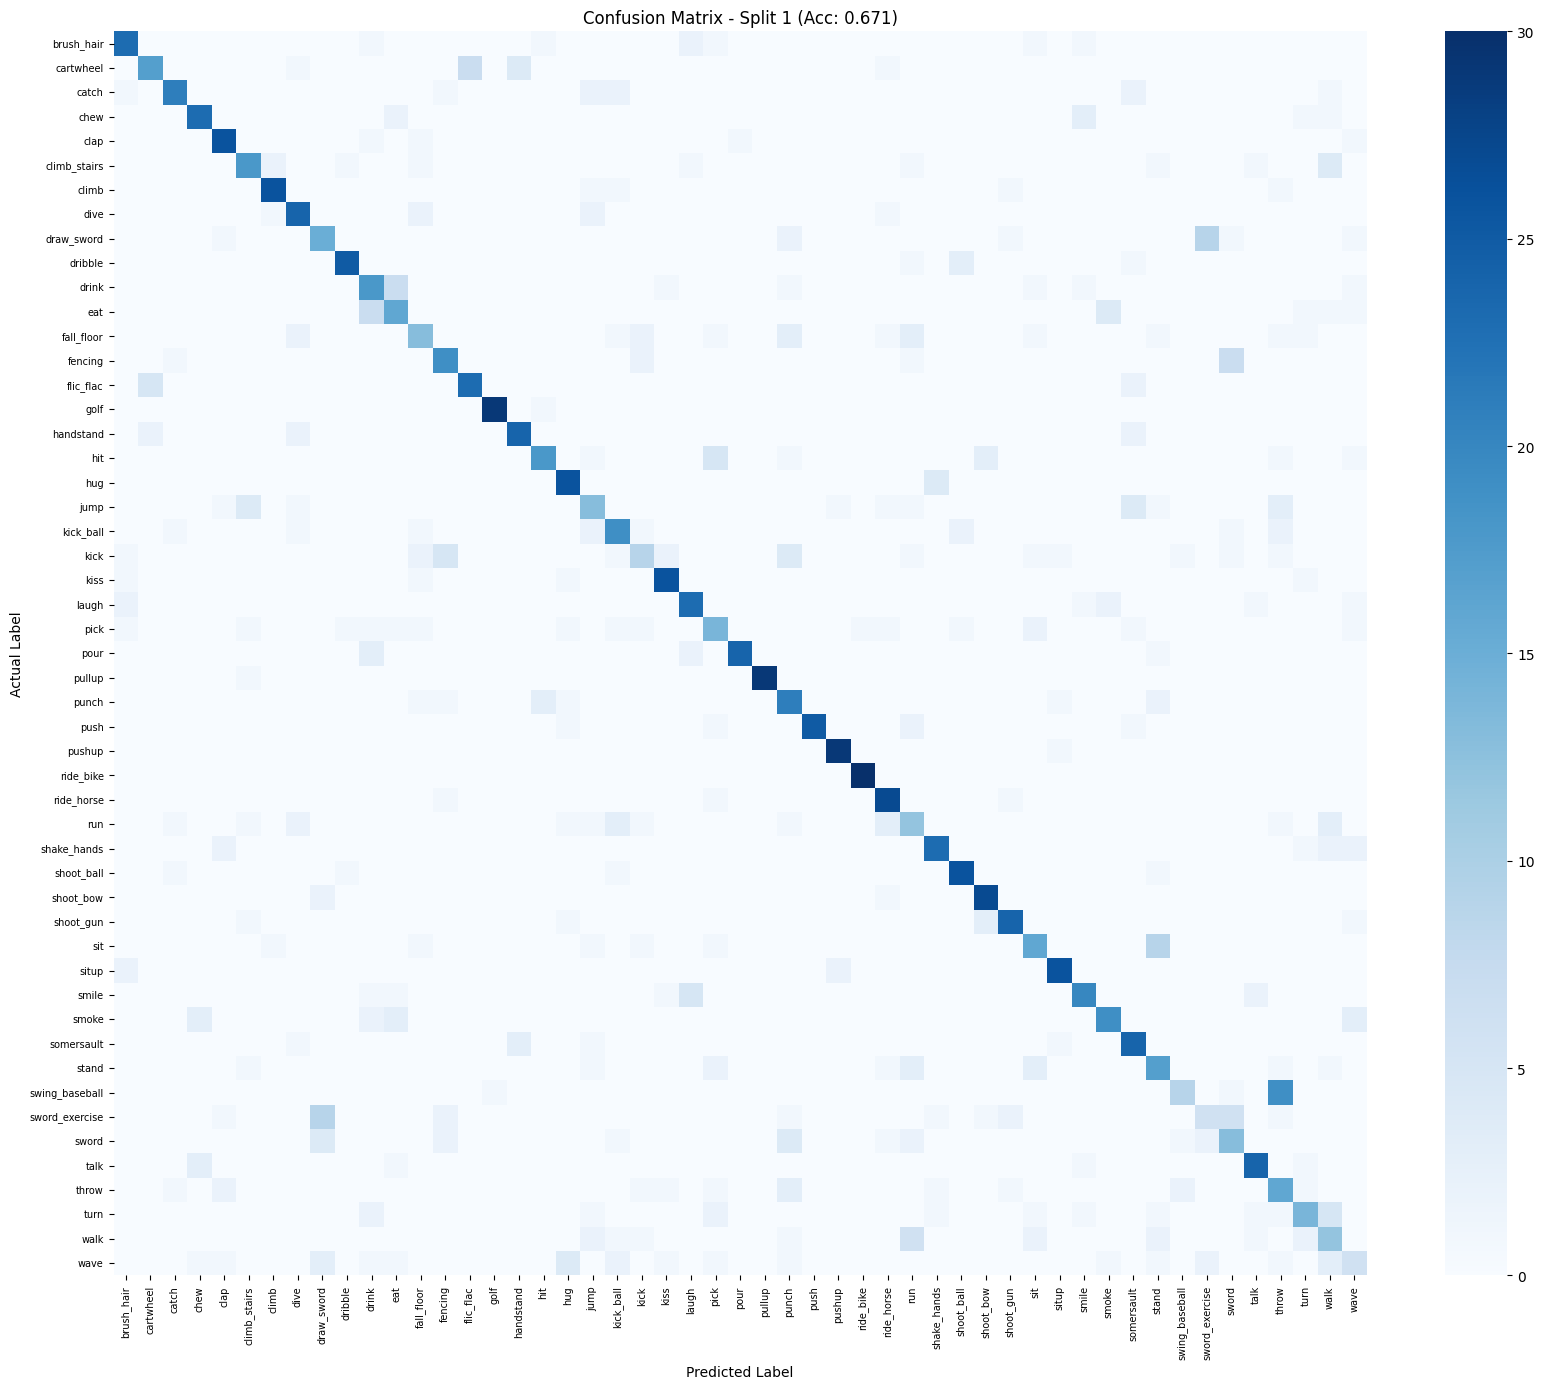

In [ ]:
# --- Full Test Set Evaluation ---
# Run only if model and test data are ready
if model_ready and test_loader is not None and action_map is not None:
    print("\n--- Starting Full Test Set Evaluation ---")
    model.eval() # Ensure eval mode
    # Ensure noise is off for evaluation
    if hasattr(model, 'moe_layer') and hasattr(model.moe_layer, 'noisy_gating_std'):
        model.moe_layer.noisy_gating_std = 0.0

    all_preds, all_labels = [], []
    inference_times = []
    batches_processed, skipped_batches = 0, 0

    print(f"Evaluating model on Test Set for Split {CURRENT_SPLIT}...")
    with torch.no_grad(): # Disable gradients for evaluation
        progress_bar = tqdm(test_loader, desc='Evaluating Test Set', leave=False)
        for batch in progress_bar:
            # Basic batch validity check
            if batch is None or len(batch) != 2 or batch[0].nelement() == 0:
                skipped_batches += 1; continue
            frames, labels = batch
            if frames is None or labels is None or frames.nelement() == 0:
                 skipped_batches += 1; continue

            frames, labels = frames.to(DEVICE), labels.to(DEVICE)
            batches_processed += 1

            try:
                start_time = time.time()
                # Forward pass - ignore auxiliary loss during evaluation
                outputs, _ = model(frames)
                inference_times.append(time.time() - start_time)

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            except RuntimeError as e:
                 if "CUDA out of memory" in str(e):
                     print("\nCUDA OOM during eval! Skipping batch."); gc.collect(); torch.cuda.empty_cache(); skipped_batches+=1; continue
                 else:
                     print(f"\nRuntime error during eval: {e}. Skipping batch."); skipped_batches+=1; continue
            except Exception as e:
                 print(f"\nUnexpected error during eval: {e}. Skipping batch."); skipped_batches+=1; continue

    print("Evaluation loop finished.")
    if skipped_batches > 0: print(f"Note: Skipped {skipped_batches} batches during evaluation.")

    # --- Calculate and Print Metrics ---
    if not all_labels:
        print("\nERROR: No labels collected during evaluation. Cannot calculate metrics.")
    else:
        print("\n--- Evaluation Metrics ---")
        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Overall Accuracy: {accuracy:.4f}")

        # Prepare labels for classification report
        label_to_action = {v: k for k, v in action_map.items()}
        num_classes_loaded = len(action_map)
        # Use labels present in ground truth or predictions for report
        report_labels = sorted(list(set(all_labels) | set(all_preds)))
        report_target_names = [label_to_action.get(i, f"Unknown_{i}") for i in report_labels]

        print("\nClassification Report:")
        try:
            class_report = classification_report(
                all_labels, all_preds, labels=report_labels, target_names=report_target_names,
                zero_division=0, digits=3 # Use 3 decimal places, handle zero division
            )
            print(class_report)
        except Exception as report_e:
            print(f"Could not generate classification report: {report_e}")


        # Inference time stats
        if inference_times:
            avg_inf_time = sum(inference_times) / len(inference_times) if inference_times else 0
            total_inf_time = sum(inference_times)
            print(f"\nAvg Inference Time / Batch: {avg_inf_time:.4f} sec")
            print(f"Total Inference Time: {total_inf_time:.2f} sec")

        # --- Confusion Matrix Plotting ---
        plot_cm = True # Set to False to disable plotting
        if plot_cm:
            print("\nGenerating Confusion Matrix...")
            try:
                cm = confusion_matrix(all_labels, all_preds, labels=report_labels)
                cm_df = pd.DataFrame(cm, index=report_target_names, columns=report_target_names)

                plt.figure(figsize=(max(12, num_classes_loaded // 3), max(10, num_classes_loaded // 3.5)))
                sns.heatmap(cm_df, annot=False, cmap='Blues', fmt='g') # Annot=False usually needed for 51 classes
                plt.title(f'Confusion Matrix - Split {CURRENT_SPLIT} (Acc: {accuracy:.3f})')
                plt.ylabel('Actual Label'); plt.xlabel('Predicted Label')
                plt.xticks(fontsize=7, rotation=90); plt.yticks(fontsize=7, rotation=0)
                plt.tight_layout(); plt.show()
            except Exception as plot_e:
                print(f"Error generating Confusion Matrix plot: {plot_e}")
        else:
             print("\nConfusion Matrix plotting disabled.")

    # Clean up GPU memory after evaluation
    gc.collect(); torch.cuda.empty_cache()
else:
    print("\nSkipping Evaluation: Model not ready or test data not loaded.")

In [ ]:
# --- Inference Function Definition (Predict Single Video) ---

def predict_video(video_path, pred_model, pred_action_map, num_frames, img_size, device):
    """Predicts the action in a single video file using the trained model."""
    # Basic input checks
    if not os.path.exists(video_path):
         print(f"Error: Video file not found at {video_path}")
         return "Video not found", 0.0
    if pred_model is None:
        print("Error: Prediction model is None.")
        return "Model error", 0.0
    if pred_action_map is None:
        print("Error: Action map is None.")
        return "Action map error", 0.0

    # Set model to evaluation mode
    pred_model.eval()
    # Ensure MoE noise is off during inference
    if hasattr(pred_model, 'moe_layer') and hasattr(pred_model.moe_layer, 'noisy_gating_std'):
        pred_model.moe_layer.noisy_gating_std = 0.0

    # --- Define Normalization Constants (match training) ---
    # View shape: (1, C, 1, 1, 1) for broadcasting across B, T, H, W
    mean = torch.tensor([0.43216, 0.394666, 0.37645], device=device).view(1, 3, 1, 1, 1)
    std = torch.tensor([0.22803, 0.22145, 0.216989], device=device).view(1, 3, 1, 1, 1)

    # --- Sample frames ---
    try:
        frames = sample_frames(video_path, num_frames, img_size)
        if frames is None:
             print(f"Error: Failed to sample frames from {video_path}")
             return "Error sampling frames", 0.0
    except Exception as e:
         print(f"Error during frame sampling for {video_path}: {e}")
         return f"Error during sampling: {e}", 0.0

    # --- Preprocess frames ---
    try:
        # Convert numpy array (T, H, W, C) to PyTorch tensor (B, C, T, H, W)
        frames_tensor = torch.from_numpy(frames).float().permute(3, 0, 1, 2) # (C, T, H, W)
        frames_tensor = frames_tensor.unsqueeze(0).to(device) # Add batch dim -> (1, C, T, H, W)

        # Normalize
        frames_tensor /= 255.0
        frames_tensor = (frames_tensor - mean) / std
    except Exception as e:
        print(f"Error during preprocessing for {video_path}: {e}")
        return f"Error preprocessing: {e}", 0.0

    # --- Get prediction ---
    try:
        with torch.no_grad(): # Disable gradients for inference
            outputs, _ = pred_model(frames_tensor) # Ignore aux loss
            if outputs is None or outputs.nelement() == 0:
                print("Error: Model returned empty output.")
                return "Model error (empty output)", 0.0

            # Get probabilities and prediction
            probabilities = F.softmax(outputs, dim=1)
            # Check for NaN probabilities which can indicate numerical instability
            if torch.isnan(probabilities).any():
                print("Warning: NaN detected in prediction probabilities.")
                return "Invalid prediction (NaN)", 0.0

            confidence, pred_label_idx = torch.max(probabilities, dim=1)
            pred_label_idx = pred_label_idx.item() # Get integer index
            confidence = confidence.item() # Get float confidence
    except Exception as e:
        print(f"Error during model inference for {video_path}: {e}")
        traceback.print_exc()
        return f"Inference error: {e}", 0.0

    # --- Map label index back to action name ---
    # Create reverse mapping if not already done
    label_to_action = {v: k for k, v in pred_action_map.items()}
    pred_action_name = label_to_action.get(pred_label_idx, f"Unknown Label ({pred_label_idx})")

    return pred_action_name, confidence

print("\nPrediction function defined.")


Prediction function defined.



--- Running Inference Example with Thumbnails ---
Selecting up to 20 sample videos from the test set...
Selected 20 videos for visualization.
Generating thumbnails and predictions...


Processing Samples:   0%|          | 0/20 [00:00<?, ?it/s]


--- Visualization ---


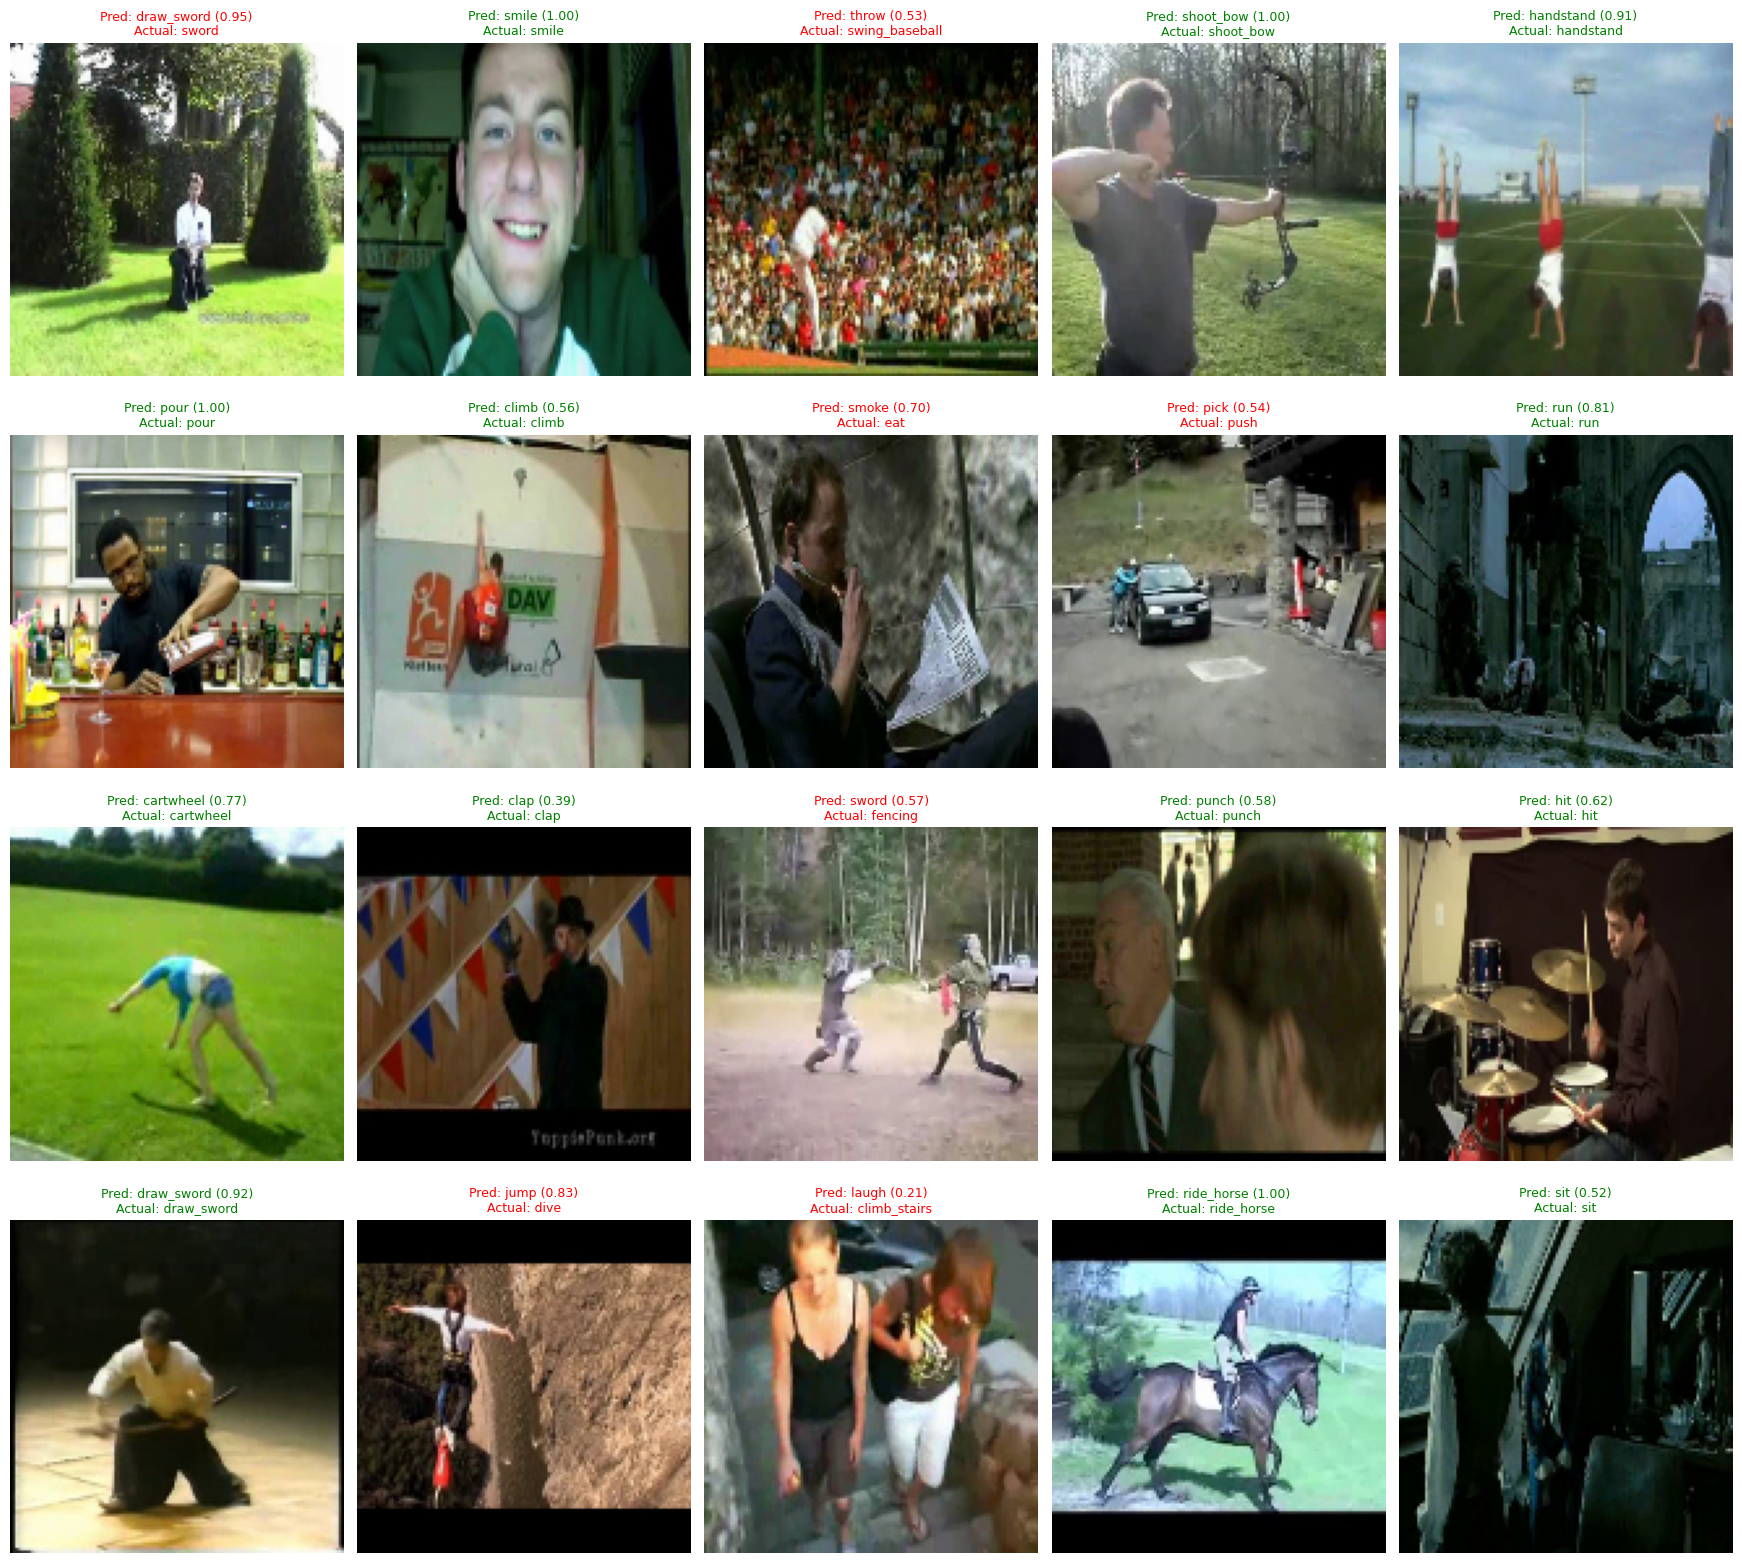

In [ ]:
# --- Inference Example with Thumbnails ---

print("\n--- Running Inference Example with Thumbnails ---")

# --- Configuration for Visualization ---
NUM_VIS_SAMPLES = 20 # Number of samples to visualize
GRID_ROWS = 4
GRID_COLS = 5
if NUM_VIS_SAMPLES > GRID_ROWS * GRID_COLS:
    print(f"Adjusting NUM_VIS_SAMPLES to fit grid: {GRID_ROWS * GRID_COLS}")
    NUM_VIS_SAMPLES = GRID_ROWS * GRID_COLS # Limit to grid size

# --- Helper function to get a thumbnail ---
def get_thumbnail(video_path, thumb_size=128):
    """Extracts the middle frame of a video as a thumbnail."""
    cap = None
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            # print(f"Warning: Could not open video for thumbnail: {video_path}") # Reduce noise
            return None
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames < 1: return None # No frames

        # Go to middle frame
        middle_frame_idx = total_frames // 2
        cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)
        ret, frame = cap.read()

        if ret:
            # Convert BGR to RGB, resize
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            thumbnail = cv2.resize(frame_rgb, (thumb_size, thumb_size), interpolation=cv2.INTER_LINEAR)
            return thumbnail
        else:
            # print(f"Warning: Could not read middle frame from {video_path}") # Reduce noise
            return None
    except Exception as e:
        # print(f"Warning: Error getting thumbnail for {video_path}: {e}") # Reduce noise
        return None
    finally:
        if cap is not None:
            cap.release()

# --- Proceed only if model and test data splits are ready ---
if model_ready and test_split_videos is not None and action_map is not None:

    # 1. Select Sample Videos from Test Set
    sample_videos_info = [] # List to store (video_path, actual_action_name)
    actions_sampled = set() # Keep track of actions already sampled from
    max_attempts_per_action = 5 # Try a few videos per action if first fails

    print(f"Selecting up to {NUM_VIS_SAMPLES} sample videos from the test set...")
    action_list = list(test_split_videos.keys())
    random.shuffle(action_list) # Shuffle for variety across runs

    for action_name in action_list:
        if len(sample_videos_info) >= NUM_VIS_SAMPLES: break # Stop once we have enough samples
        if action_name in test_split_videos and test_split_videos[action_name]:
            candidates = test_split_videos[action_name]; random.shuffle(candidates)
            attempts = 0
            for video_name in candidates:
                 if attempts >= max_attempts_per_action: break # Move to next action if cant find valid video
                 potential_path = os.path.join(DATASET_PATH, action_name, video_name.strip())
                 # Check if path exists and seems valid (basic size check)
                 if os.path.exists(potential_path):
                      try:
                           if os.path.getsize(potential_path) > 1024: # Basic check for non-empty file
                               sample_videos_info.append((potential_path, action_name))
                               actions_sampled.add(action_name)
                               # Take only one sample per action class for better visual variety
                               break # Move to the next action class
                           else: attempts += 1
                      except OSError: attempts += 1 # Skip if cannot get size
                 else: attempts += 1
        # Check if we have enough samples after processing an action
        if len(sample_videos_info) >= NUM_VIS_SAMPLES: break

    print(f"Selected {len(sample_videos_info)} videos for visualization.")

    # 2. Get Thumbnails and Predictions
    results = []
    if sample_videos_info:
        print("Generating thumbnails and predictions...")
        for video_path, actual_action in tqdm(sample_videos_info, desc="Processing Samples"):
            thumbnail = get_thumbnail(video_path)
            if thumbnail is None:
                print(f"Skipping {os.path.basename(video_path)}: Could not get thumbnail.")
                continue # Skip if thumbnail failed

            predicted_action, confidence = predict_video(
                video_path, model, action_map, NUM_FRAMES, IMG_SIZE, DEVICE)

            # Store result only if prediction didn't obviously fail
            if not predicted_action.lower().startswith("error") and "unknown" not in predicted_action.lower():
                 results.append({
                     'thumbnail': thumbnail,
                     'predicted': predicted_action,
                     'actual': actual_action,
                     'confidence': confidence
                 })
            else:
                 print(f"Skipping result for {os.path.basename(video_path)} due to prediction error: {predicted_action}")
    else:
        print("No valid sample videos were selected or processed.")


    # 3. Display Results in a Grid
    if results:
        print("\n--- Visualization ---")
        fig, axes = plt.subplots(GRID_ROWS, GRID_COLS, figsize=(GRID_COLS * 3.5, GRID_ROWS * 4)) # Adjust figsize
        axes = axes.ravel() # Flatten the axes array

        for i, res in enumerate(results):
            if i >= len(axes): break # Stop if we have more results than grid cells

            ax = axes[i]
            ax.imshow(res['thumbnail'])
            title_color = 'green' if res['predicted'] == res['actual'] else 'red'
            ax.set_title(f"Pred: {res['predicted']} ({res['confidence']:.2f})\nActual: {res['actual']}",
                         color=title_color, fontsize=9) # Smaller font size
            ax.axis('off') # Hide axes ticks

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout(pad=1.0) # Adjust padding
        plt.show()
    else:
        print("No valid results were generated to display.")

else:
    print("\nSkipping Inference Visualization: Model or test data not ready.")

In [ ]:
# --- User Input Video Inference ---

print("\n--- Cell 18: User Video Inference ---")

# --- Ensure necessary components are available ---
# Check if functions/variables from previous cells exist
required_vars = ['model_ready', 'model', 'action_map', 'predict_video', 'get_thumbnail',
                 'NUM_FRAMES', 'IMG_SIZE', 'DEVICE', 'USER_UPLOAD_PATH']
if not all(var in globals() for var in required_vars):
    print("ERROR: Not all required variables/functions are defined. Please run previous cells.")
else:
    # --- Create Upload Widget ---
    uploader = widgets.FileUpload(
        accept='.avi,.mp4,.mov,.mpg,.mpeg,.wmv',  # Common video formats
        multiple=False,  # Single file upload
        description='Upload Video'
    )

    # --- Output areas ---
    output_area = widgets.Output() # For text messages and results
    thumbnail_area = widgets.Output() # For displaying the thumbnail
    button_area = widgets.Output() # For the predict button

    # --- Global variable to store uploaded video path ---
    uploaded_video_path = None

    # --- Helper Function Definitions ---
    def clear_all_outputs():
        """Clears the output areas."""
        output_area.clear_output()
        thumbnail_area.clear_output()
        button_area.clear_output()

    def on_upload_change(change):
        """Handles file upload event: saves file, displays thumbnail, shows button."""
        global uploaded_video_path
        # Use output_area context manager to capture prints/errors within the callback
        with output_area:
            # print("--- Upload Change Triggered ---") # Debug: Check if callback runs
            clear_all_outputs() # Clear previous results on new upload

            if not change['new']: # Check if upload was cleared/cancelled
                # print("Upload value cleared or cancelled.")
                uploaded_video_path = None
                return # Exit if no file

            try:
                # --- Robust File Access (Handles Dict or Tuple/List) ---
                upload_data = uploader.value # Get the uploaded value
                # print(f"DEBUG: Type of uploader.value: {type(upload_data)}") # Debug type

                if isinstance(upload_data, dict) and upload_data:
                    # Standard dictionary access (most common case)
                    uploaded_filename = list(upload_data.keys())[0]
                    file_info = upload_data[uploaded_filename]
                elif isinstance(upload_data, (tuple, list)) and upload_data and isinstance(upload_data[0], dict):
                     # Handle cases where value might be wrapped in a tuple/list
                    file_info = upload_data[0] # Get the dictionary
                    # Get filename from metadata if available, otherwise generate one
                    uploaded_filename = file_info.get('metadata', {}).get('name', f'uploaded_file_{int(time.time())}')
                    # Basic extension guessing if filename lacks one
                    if '.' not in uploaded_filename:
                        mime_type = file_info.get('metadata',{}).get('type','')
                        ext_map = { 'mp4': '.mp4', 'avi': '.avi', 'mov': '.mov', 'quicktime': '.mov', 'mpeg': '.mpg', 'wmv': '.wmv', 'ms-wmv': '.wmv'}
                        ext = next((v for k, v in ext_map.items() if k in mime_type), '') # Find first matching extension
                        uploaded_filename += ext
                else:
                    print(f"ERROR: Unexpected type or empty data for uploader.value: {type(upload_data)}")
                    return
                # --- End Robust File Access ---

                uploaded_content = file_info.get('content', None)
                if uploaded_content is None:
                     print("ERROR: Could not extract file content from upload data.")
                     return

                print(f"File selected: {uploaded_filename} ({len(uploaded_content)/1024:.1f} KB)")

                # Ensure upload directory exists
                os.makedirs(USER_UPLOAD_PATH, exist_ok=True)
                # Sanitize filename slightly before saving
                safe_filename = uploaded_filename.replace(" ", "_").replace("/", "_").replace("\\", "_")
                uploaded_video_path = os.path.join(USER_UPLOAD_PATH, safe_filename)
                # print(f"Attempting to save to: {uploaded_video_path}")

                # Save the uploaded file
                with open(uploaded_video_path, 'wb') as f:
                    f.write(uploaded_content)
                print(f"Video saved successfully.")

                # --- Thumbnail Generation ---
                # print("Attempting to generate thumbnail...")
                thumbnail = get_thumbnail(uploaded_video_path, thumb_size=224) # Larger thumbnail
                thumbnail_area.clear_output() # Clear previous thumbnail
                if thumbnail is not None:
                    # print("Thumbnail generated. Encoding and displaying...")
                    try:
                        # Convert numpy array (RGB) to displayable image format (e.g., PNG)
                        _, buffer = cv2.imencode('.png', cv2.cvtColor(thumbnail, cv2.COLOR_RGB2BGR)) # Encode as PNG
                        img_str = base64.b64encode(buffer).decode('utf-8')
                        # Display using HTML img tag for better control
                        with thumbnail_area:
                             display(HTML(f'<img src="data:image/png;base64,{img_str}" alt="Thumbnail" style="max-width: 224px; height: auto; border: 1px solid #ccc;"/>'))
                        # print("Thumbnail displayed.")
                    except Exception as thumb_disp_e:
                        print(f"ERROR displaying thumbnail: {thumb_disp_e}")
                        with thumbnail_area: print("(Error displaying thumbnail)")
                else:
                    # print("Could not generate thumbnail.")
                    with thumbnail_area: print("(No thumbnail available)")

                # --- Display Predict Button ---
                # print("Attempting to display predict button...")
                display_predict_button()
                # print("Predict button should be displayed.")

            except Exception as e:
                print(f"\n--- ERROR during upload processing ---")
                print(f"Error type: {type(e).__name__}")
                print(f"Error details: {e}")
                print("Traceback:")
                traceback.print_exc() # Print detailed traceback
                uploaded_video_path = None # Reset path on error


    def display_predict_button():
         """Creates and displays the predict button."""
         predict_button = widgets.Button(description="Predict Action", button_style='success', icon='play')
         # Assign the click handler
         predict_button.on_click(on_predict_button_clicked)
         button_area.clear_output() # Clear previous button first
         # Display the button in its designated area
         with button_area:
             display(predict_button)


    def on_predict_button_clicked(b):
        """Handles predict button click: runs inference and displays results."""
        global uploaded_video_path
        output_area.clear_output() # Clear previous prediction text

        # Use output_area context manager to ensure prints appear correctly
        with output_area:
            print("--- Predict Button Clicked ---")
            # --- Check Prerequisites ---
            if not model_ready: print("ERROR: Model is not ready."); return
            if uploaded_video_path is None or not os.path.exists(uploaded_video_path): print("ERROR: No valid video uploaded or file path missing."); return
            if model is None: print("ERROR: 'model' variable is None."); return
            if action_map is None: print("ERROR: Action map (for labels) is missing."); return
            if 'predict_video' not in globals(): print("ERROR: predict_video function definition is missing."); return
            # --- End Prerequisite Check ---

            print(f"Running prediction on: {os.path.basename(uploaded_video_path)}...")
            start_pred_time = time.time()

            try:
                # Call the prediction function
                predicted_action, confidence = predict_video(
                    uploaded_video_path,
                    model,               # The loaded/trained model
                    action_map,          # The mapping from ID to action name
                    NUM_FRAMES,          # From config
                    IMG_SIZE,            # From config
                    DEVICE               # From config
                )
                pred_duration = time.time() - start_pred_time

                # Display results
                print("\n" + "=" * 30)
                if predicted_action.lower().startswith("error") or "unknown" in predicted_action.lower() or "not found" in predicted_action.lower():
                    print(f"Prediction Failed / Unknown: {predicted_action}")
                else:
                    print(f"Predicted Action: {predicted_action}")
                    print(f"Confidence: {confidence:.4f}")
                print(f"(Inference Time: {pred_duration:.2f}s)")
                print("=" * 30)

            except Exception as pred_e:
                 print("\n--- ERROR during prediction execution ---")
                 print(f"Type: {type(pred_e).__name__}, Details: {pred_e}")
                 print("Traceback:")
                 traceback.print_exc()

    # --- Observe changes in the uploader ---
    try:
        # Attempt to remove previous observer if cell is re-run to avoid duplicates
        uploader.unobserve(on_upload_change, names='value')
    except ValueError:
        pass # Ignore if observer wasn't attached previously
    # Attach the handler function to the 'value' trait of the uploader
    uploader.observe(on_upload_change, names='value')

    # --- Display the widgets ---
    print("\n--- User Inference Interface ---")
    print("Please upload a video file using the button below.")
    print("Supported formats: .avi, .mp4, .mov, .mpg, .mpeg, .wmv")
    display(uploader)
    display(thumbnail_area) # Area for thumbnail
    display(button_area)  # Area for button
    display(output_area)  # Area for messages/results


--- Cell 18: User Video Inference ---

--- User Inference Interface ---
Please upload a video file using the button below.
Supported formats: .avi, .mp4, .mov, .mpg, .mpeg, .wmv


FileUpload(value=(), accept='.avi,.mp4,.mov,.mpg,.mpeg,.wmv', description='Upload Video')

Output()

Output()

Output()

In [ ]:
## End of Notebook
"""
- The enhanced model checkpoint (if training occurred) is saved in `/kaggle/working/models/`.
- Extracted data is in `/kaggle/working/data/`.
- User uploads are temporarily saved in `/kaggle/working/user_uploads`.
- Files in `/kaggle/working/` persist across sessions but can be deleted manually if needed.
- To **force retraining** for the `CURRENT_SPLIT`, delete the corresponding `.pth` file from `/kaggle/working/models/`, or uncomment the optional "Clear Saved Model" cell (Cell 13). """

'\n- The enhanced model checkpoint (if training occurred) is saved in `/kaggle/working/models/`.\n- Extracted data is in `/kaggle/working/data/`.\n- User uploads are temporarily saved in `/kaggle/working/user_uploads`.\n- Files in `/kaggle/working/` persist across sessions but can be deleted manually if needed.\n- To **force retraining** for the `CURRENT_SPLIT`, delete the corresponding `.pth` file from `/kaggle/working/models/`, or uncomment the optional "Clear Saved Model" cell (Cell 13). '